# 1: Save

This notebook, along with its companion notebook [`load.ipynb`](load.ipynb), illustrates the process of saving a neural network model and its weights using TensorFlow, then loading them to be run as part of a separate program.

Some details of saving and loading are non-obvious, and require a clear understanding of TensorFlow's abstraction. As a programmer of perhaps intermediate skills, it took me a while to grasp all of this, but once you've figured it out, saving and loading is very straightforward.

## Build the model

The code in the block below is mostly copied straight from TensorFlow's [*Deep MNIST for Experts*](https://www.tensorflow.org/versions/r0.10/tutorials/mnist/pros/index.html) tutorial, which is a good introduction to convolutional neural networks. This code trains a CNN to classify handwritten images using the MNIST dataset. Read the tutorial if you're interested in an introduction to convolution and/or TensorFlow; I'll reproduce the tutorial code as compactly as possible in order to move on to the saving bit.

I've made just a few modifications to the code below from what's published in TensorFlow's tutorial: I'm only running 1,000 iterations of the training step to save time (instead of 20,000) because accuracy isn't essential here. And I've added `name` flags to three variables: `x`, `keep_prob`, and `y_conv`. The addition of names will make sense later.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
import tensorflow as tf

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
sess = tf.InteractiveSession()

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

x = tf.placeholder(tf.float32, shape=[None, 784], name="input")
y_ = tf.placeholder(tf.float32, shape=[None, 10])

W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_image = tf.reshape(x, [-1,28,28,1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32, name="keep_prob")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2, name="output")

sess.run(tf.initialize_all_variables())

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())

# To make this run faster, we'll only run 1,000 iterations of the training process.
for i in range(1000):
  batch = mnist.train.next_batch(50)
  if i%100 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.08
step 100, training accuracy 0.84
step 200, training accuracy 0.92
step 300, training accuracy 0.88
step 400, training accuracy 1
step 500, training accuracy 0.96
step 600, training accuracy 1
step 700, training accuracy 0.94
step 800, training accuracy 0.94
step 900, training accuracy 1
test accuracy 0.962


## Run the model

Let's take a moment to review how this model can be used to classify a new image. We'll begin with an arbitrary image from the MNIST validation set and display it.

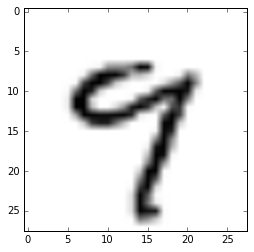

In [3]:
image_a = mnist.validation.images[154]
plt.imshow(image_a.reshape([28, 28]), cmap='Greys')

So, this image is the digit 9. Let's run it through the model to see if the model agrees that it's a 9.

The output of the model is the variable `y_conv`. To evaluate `y_conv`, we need to call `sess.run`, and we tell TensorFlow what to use as the model's inputs by feeding the inputs as a `feed_dict`.

The MNIST convlutional neural network requires two inputs: `x`, which is the image we're trying to classify, and `keep_prob`, which is used in the dropout step in training, but will be 1 when we run the model here.

The output of the model, `y_conv`, is a tensor consisting of a 1 x 10 list of probabilities; for any digit `n` between 0 and 9, `y_conv[n]` is the model's estimate of the probability that the image we fed in as `x` represents `n`. The last line below prints the index of the higest value in the `y_conv` list, which should be the digit we're looking for. We begin by reshaping `image_a` into a 1 x 784 matrix, which is the shape that `x` anticipates.

In [4]:
image_a = image_a.reshape([1, 784])
result = sess.run(y_conv, feed_dict={x:image_a, keep_prob:1})
print(result)
print(sess.run(tf.argmax(result, 1)))

[[  1.02318620e-04   8.09151788e-06   4.57409551e-05   2.90626520e-03
    1.85008347e-02   5.09861100e-04   1.31173074e-05   3.49079758e-01
    1.04696560e-03   6.27787113e-01]]
[9]


The model will prodce a slightly different result each time it's trained, but I got what I'm expecting: the model correctly says this handwritten digit is a 9, with roughly 82% certainty. The next closest guess is that it's a 7, with 17% certainty. That makes sense; this digit does indeed look a bit like a 7.

## Save the model

So, we've trained this model and we've seen how to run it. Now we want to save it so it can be reinstated in another program and used to classify images there.

The key realization at this point is that the TensorFlow model and its weights are different things, and it's possible to export one or the other. We want to export both. The model, or graph definition, defines the variables, the computational steps, and the links between them. The weights are the model values that we developed by training the model a few minutes ago.

To save the model, we use a TensorFlow `saver`. The code below saves the model into our current working directory as two files: `saved_mnist_cnn.ckpt`, which contains the weights, and `saved_mnist_cnn.ckpt.meta`, which contains the graph definition.

In [5]:
saver = tf.train.Saver()
save_path = saver.save(sess, "saved_mnist_cnn.ckpt")
print("Model saved to %s" % save_path)

Model saved to saved_mnist_cnn.ckpt


## Move on to part 2

To demonstrate loading, we'll move on to a new file: [2: Load](load.ipynb)